**Урок 5.**<br>
**Задание:** реализовать оценку Out-of-Bag ошибок для каждого из деревьев леса.

In [23]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random


from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [24]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

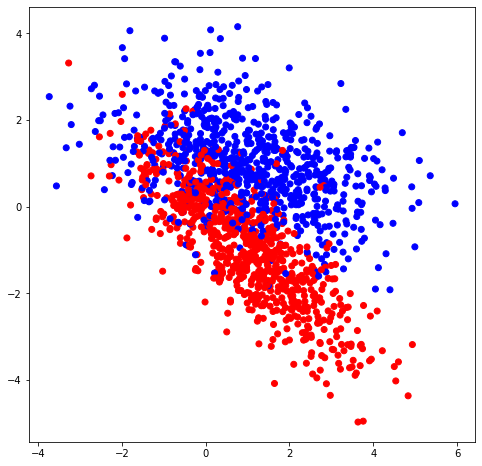

In [25]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [26]:
random.seed(42)

def get_bootstrap(data, labels, N):
    '''Updated'''
    n_samples = data.shape[0]
    bootstrap = []
    forest_indices = []  # Сюда пишу индексы по всем деревьям леса
    
    for i in range(N):
        tree_indices = set()  # Сюда пишу индексы в рамках 1 дерева
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            tree_indices.add(sample_index)  # Добавляю все выпавшие индексы, включая повторы
        bootstrap.append((b_data, b_labels))
        forest_indices.append(tree_indices)  # Отправляю в forest_indices лист с индексами дерева

    return bootstrap, forest_indices

In [27]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [28]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [29]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [30]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [31]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [32]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [33]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [34]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [35]:
def random_forest(data, labels, n_trees):
    '''Updated'''
    forest = []
    bootstrap, forest_indices = get_bootstrap(data, labels, n_trees)  # Прокидываем дальше индексы, собранные во время бутстрапа
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, forest_indices

In [36]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [37]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [38]:
# предсказание голосованием деревьев

def oob_tree_vote(forest, data, forest_indices):
    '''Updated'''
    
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # сформируем маску, чтобы оставить только OOB голоса 
    predictions_mask_oob = []
    for i in range(data.shape[0]):
        index_mask = []
        for tree_indices in forest_indices:
            if i in tree_indices:
                index_mask.append(False)
            else:
                index_mask.append(True)
        predictions_mask_oob.append(index_mask)

    predictions_per_object_masked_oob = np.ma.masked_array(predictions_per_object, mask=predictions_mask_oob)  # Маска исключает x_{i}, которые участвовали в обучении соответствующего дерева 
    
    # Применение маски даёт на выходе список с OOB голосами
    predictions_per_object_masked_oob_fixed = []
    for i in range(len(predictions_per_object_masked_oob)):
        predictions_per_object_masked_oob_fixed.append(list(predictions_per_object_masked_oob[i].compressed()))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    oob_voted_predictions = []
    for obj in predictions_per_object_masked_oob_fixed:
        if obj == []:
            oob_voted_predictions.append(None)  # Это если для наблюдения не было OOB
        else:
            oob_voted_predictions.append(max(set(obj), key=obj.count))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return oob_voted_predictions, voted_predictions

In [39]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric_oob(actual, predicted):
    '''Updated'''

    # Сначала отброшу значения, где прогноз сделать не получилось из-за отсутствия OOB
    index = []
    for i in range(len(predicted)):
        if predicted[i] == None or actual[i] == None:
            index.append(i)
    predicted = np.delete(predicted, i, None)
    actual = np.delete(actual, i, None)

    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [40]:
def run_forest_and_see_metrics(data, labels, n_trees):
    '''Для удобства объединил построение случайного леса и вывод метрик'''

    my_forest, forest_indices = random_forest(data, labels, n_trees)
    # Получим ответы для обучающей и OOB выборки 
    oob_voted_predictions, voted_predictions = oob_tree_vote(my_forest, data, forest_indices)
    # Точность на обучающей выборке
    all_accuracy = accuracy_metric_oob(labels, voted_predictions)
    print(f'Точность случайного леса из {n_trees} деревьев на всей выборке: {all_accuracy:.3f}')
    # Точность на OOB выборке
    oob_accuracy = accuracy_metric_oob(labels, oob_voted_predictions)
    print(f'Точность случайного леса из {n_trees} деревьев на OOB (тестовой) выборке: {oob_accuracy:.3f}')

In [41]:
n_trees = 1
run_forest_and_see_metrics(classification_data, classification_labels, n_trees)

Точность случайного леса из 1 деревьев на всей выборке: 95.864
Точность случайного леса из 1 деревьев на OOB (тестовой) выборке: 63.709


In [42]:
n_trees = 3
run_forest_and_see_metrics(classification_data, classification_labels, n_trees)

Точность случайного леса из 3 деревьев на всей выборке: 97.732
Точность случайного леса из 3 деревьев на OOB (тестовой) выборке: 92.728


In [43]:
n_trees = 5
run_forest_and_see_metrics(classification_data, classification_labels, n_trees)

Точность случайного леса из 5 деревьев на всей выборке: 97.932
Точность случайного леса из 5 деревьев на OOB (тестовой) выборке: 97.865


In [44]:
n_trees = 7
run_forest_and_see_metrics(classification_data, classification_labels, n_trees)

Точность случайного леса из 7 деревьев на всей выборке: 98.332
Точность случайного леса из 7 деревьев на OOB (тестовой) выборке: 98.466
